In [1]:
import pywt
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
df_indic  = pd.read_csv('data.csv')
df_indic.set_index('date', inplace = True)
#df_indic.drop(columns = 'price', inplace = True)
#df['price'] = df_transform
#df_indic.dropna(inplace = True)

In [6]:
url_glassnode = 'https://api.glassnode.com/v1/metrics/market/price_drawdown_relative'
parameters = {
     'api_key' : '03d4ead5-ef03-43eb-86fd-777b7671fad2',
     'a' : 'BTC'
             }

In [7]:
data = requests.get(url  = url_glassnode, params = parameters).json()

In [8]:
date = []
price = []
for i in range(len(data)) : 
    date.append(data[i]['t'])
    price.append(data[i]['v'])
df = pd.DataFrame(date, columns = ['date'])
df['price'] = price
df['date'] = pd.to_datetime(df['date'], unit = 's')
df.set_index('date', inplace = True)
df = df + 1 

In [4]:
df  = pd.read_csv('data_2.csv').set_index('date').dropna()

In [15]:
ca , cb = pywt.wavedec(df['close'].values, 'haar', level = 1)
cat = pywt.threshold(ca, np.std(ca), mode = 'soft')
cbt = pywt.threshold(cb, np.std(cb), mode = 'soft')
#cct = pywt.threshold(cc, np.std(cc), mode = 'soft')
#cdt = pywt.threshold(cd, np.std(cd), mode = 'soft')
coeff = [cat , cbt ]
#cct , cdt]
df_transform = pywt.waverec(coeff, 'haar')

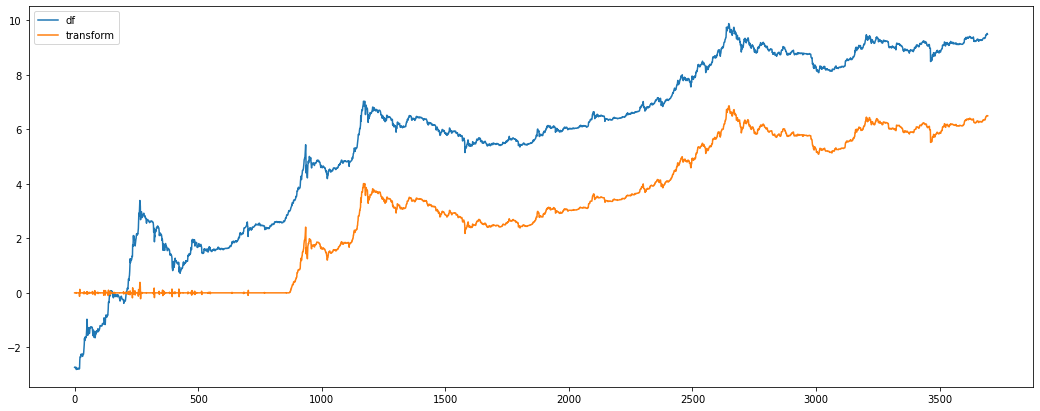

In [16]:
plt.figure(figsize = (18,7))
plt.plot(df['close'].values, label ='df')
plt.plot(df_transform, label = 'transform')
plt.legend()

In [19]:
df_transform[3000:3010]

array([5.27037366, 5.26262516, 5.15654665, 5.15654665, 5.17801949,
       5.17801949, 5.15484683, 5.15484683, 5.13481904, 5.13481904])

In [262]:
from tensorflow.keras.layers import Dense , Input , LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import regularizers

In [224]:
input_data = Input(shape=(1, 14))

encoded1 = Dense(14, activation="relu", activity_regularizer=regularizers.l2(0))(input_data)
#encoded2 = Dense(7, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
encoded2 = Dense(1, activation="relu", activity_regularizer=regularizers.l2(0))(encoded1)
        
#decoded1 = Dense(1, activation="relu", activity_regularizer=regularizers.l2(0))(encoded3)
#decoded2 = Dense(7, activation="relu", activity_regularizer=regularizers.l2(0))(decoded1)
decoded = Dense(14, activation="linear", activity_regularizer=regularizers.l2(0))(encoded2)

autoencoder = Model(inputs=input_data, outputs=decoded)
encoder = Model(input_data, encoded2)

In [225]:
autoencoder.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])

In [185]:
X = np.array(df_indic)
X = X.reshape(len(X), 1, 14)

In [226]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = autoencoder.fit(X,X,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 64,
                   shuffle = True)

Epoch 1/1000
40/40 [==============================] - 0s 5ms/step - loss: 0.0131 - mae: 0.0568 - val_loss: 0.0064 - val_mae: 0.0423
Epoch 2/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0107 - mae: 0.0517 - val_loss: 0.0054 - val_mae: 0.0392
Epoch 3/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0095 - mae: 0.0499 - val_loss: 0.0046 - val_mae: 0.0378
Epoch 4/1000
40/40 [==============================] - 0s 1ms/step - loss: 0.0084 - mae: 0.0480 - val_loss: 0.0038 - val_mae: 0.0342
Epoch 5/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0074 - mae: 0.0456 - val_loss: 0.0034 - val_mae: 0.0321
Epoch 6/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0067 - mae: 0.0437 - val_loss: 0.0031 - val_mae: 0.0305
Epoch 7/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.0061 - mae: 0.0421 - val_loss: 0.0029 - val_mae: 0.0295
Epoch 8/1000
40/40 [==============================] - 0s 2ms/step - loss: 0.

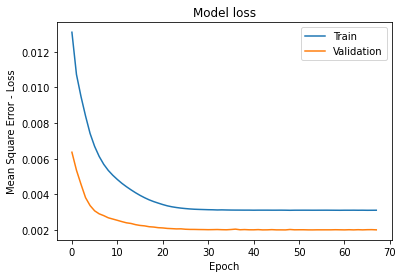

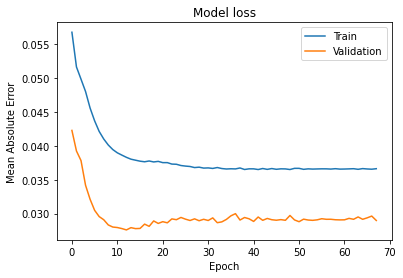

In [227]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [229]:
X_encode = autoencoder.predict(X)

In [ ]:
new_df = pd.DataFrame(X_encode)
df_indic.reset_index(inplace = True)
new_df['price'] = df_indic['price']

In [357]:
def get_sample(df, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = df.shape[0] - temporal_horizon - length

    random_start = np.random.randint(0, last_possible)
    X_sample = df.drop(columns = 'price')[random_start: random_start+length].values
    y_sample = df['price'][random_start+length: random_start+length+temporal_horizon+1]
    
   # if y_sample != y_sample:
        #X_sample, y_sample = get_sample(df, length, temporal_horizon)
    
    return X_sample, y_sample

def get_X_y(df, temporal_horizon, length_of_sequences):
    X, y = [], []

    for len_ in length_of_sequences:
        xi, yi = get_sample(df, len_, temporal_horizon)
        X.append(xi)
        y.append(yi)
        
    return X, np.array(y)

def generate_data(df, temporal_horizon, length_of_sequences):
    X, y = get_X_y(df, temporal_horizon, length_of_sequences)
    

    n_train = int(0.7*len(X))

    X_train, X_test = X[:n_train], X[n_train:]
    y_train, y_test = y[:n_train], y[n_train:]
    
    
    return X_train, X_test, y_train, y_test

In [358]:
n_days = 10
length = 30
length_of_sequences = [length for x in range(3500)]

X_train, X_test, y_train, y_test = generate_data(new_df, n_days, length_of_sequences)

In [359]:
def init_model() :
    model = Sequential()               
    model.add(LSTM(150,activation = 'tanh',input_shape=(30, 14),return_sequences = True))
    model.add(Dropout(0.5))  
    model.add(Bidirectional(LSTM(120, activation = 'tanh',return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(100,activation = 'tanh',return_sequences = True)))
    model.add(Dropout(0.5))
    model.add(LSTM(80,activation = 'tanh'))
    model.add(Dense(60,activation = 'relu'))     
    model.add(Dense(10,activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'rmsprop',metrics = ['mae'])

    return model

In [360]:
from tensorflow.keras.callbacks import EarlyStopping
model = init_model()
es = EarlyStopping(monitor = 'val_loss',mode = 'min' , verbose = 1, patience = 20, restore_best_weights = True)
history = model.fit(np.array(X_train), y_train,
                    validation_split = 0.3,
                   callbacks = [es], 
                   epochs = 1000, 
                   batch_size = 32)
                   #shuffle = True)

Epoch 1/1000
54/54 [==============================] - 6s 110ms/step - loss: 0.0202 - mae: 0.0975 - val_loss: 0.0087 - val_mae: 0.0688
Epoch 2/1000
54/54 [==============================] - 4s 81ms/step - loss: 0.0097 - mae: 0.0738 - val_loss: 0.0106 - val_mae: 0.0764
Epoch 3/1000
54/54 [==============================] - 4s 74ms/step - loss: 0.0091 - mae: 0.0718 - val_loss: 0.0079 - val_mae: 0.0628
Epoch 4/1000
54/54 [==============================] - 4s 72ms/step - loss: 0.0078 - mae: 0.0659 - val_loss: 0.0071 - val_mae: 0.0633
Epoch 5/1000
54/54 [==============================] - 4s 73ms/step - loss: 0.0071 - mae: 0.0620 - val_loss: 0.0120 - val_mae: 0.0742
Epoch 6/1000
54/54 [==============================] - 4s 73ms/step - loss: 0.0070 - mae: 0.0610 - val_loss: 0.0069 - val_mae: 0.0562
Epoch 7/1000
54/54 [==============================] - 4s 73ms/step - loss: 0.0064 - mae: 0.0567 - val_loss: 0.0078 - val_mae: 0.0626
Epoch 8/1000
54/54 [==============================] - 4s 74ms/step -

54/54 [==============================] - 4s 76ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 0.0019 - val_mae: 0.0252
Epoch 124/1000
54/54 [==============================] - 4s 73ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 0.0019 - val_mae: 0.0271
Epoch 125/1000
54/54 [==============================] - 4s 74ms/step - loss: 9.6184e-04 - mae: 0.0209 - val_loss: 0.0015 - val_mae: 0.0224
Epoch 126/1000
54/54 [==============================] - 4s 75ms/step - loss: 0.0012 - mae: 0.0216 - val_loss: 0.0017 - val_mae: 0.0240
Epoch 127/1000
54/54 [==============================] - 4s 73ms/step - loss: 0.0011 - mae: 0.0211 - val_loss: 0.0019 - val_mae: 0.0249
Epoch 128/1000
54/54 [==============================] - 4s 75ms/step - loss: 9.3035e-04 - mae: 0.0207 - val_loss: 0.0018 - val_mae: 0.0230
Epoch 129/1000
54/54 [==============================] - 4s 74ms/step - loss: 0.0010 - mae: 0.0206 - val_loss: 0.0019 - val_mae: 0.0260
Epoch 130/1000
54/54 [==============================] - 4s 76m

54/54 [==============================] - 4s 72ms/step - loss: 3.9414e-04 - mae: 0.0127 - val_loss: 0.0014 - val_mae: 0.0162
Epoch 241/1000
54/54 [==============================] - 4s 72ms/step - loss: 3.6558e-04 - mae: 0.0124 - val_loss: 0.0012 - val_mae: 0.0161
Epoch 242/1000
54/54 [==============================] - 4s 72ms/step - loss: 4.4606e-04 - mae: 0.0127 - val_loss: 6.6282e-04 - val_mae: 0.0146
Epoch 243/1000
54/54 [==============================] - 4s 73ms/step - loss: 3.4827e-04 - mae: 0.0123 - val_loss: 6.4993e-04 - val_mae: 0.0136
Epoch 244/1000
54/54 [==============================] - 4s 79ms/step - loss: 3.8171e-04 - mae: 0.0129 - val_loss: 9.9188e-04 - val_mae: 0.0156
Epoch 245/1000
54/54 [==============================] - 4s 83ms/step - loss: 4.2344e-04 - mae: 0.0127 - val_loss: 6.6606e-04 - val_mae: 0.0136
Epoch 246/1000
54/54 [==============================] - 5s 85ms/step - loss: 3.6439e-04 - mae: 0.0123 - val_loss: 0.0012 - val_mae: 0.0143
Epoch 247/1000
54/54 [====

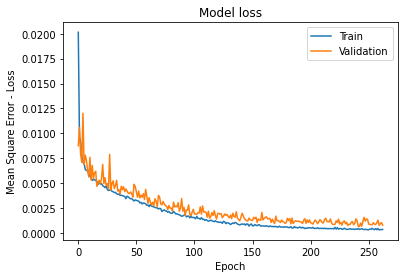

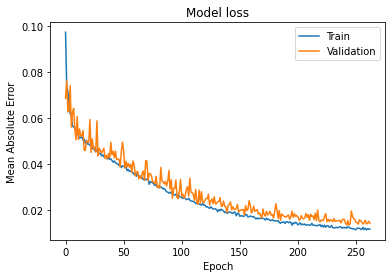

In [361]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Square Error - Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model loss')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
plot_loss(history)

In [386]:
x = 13

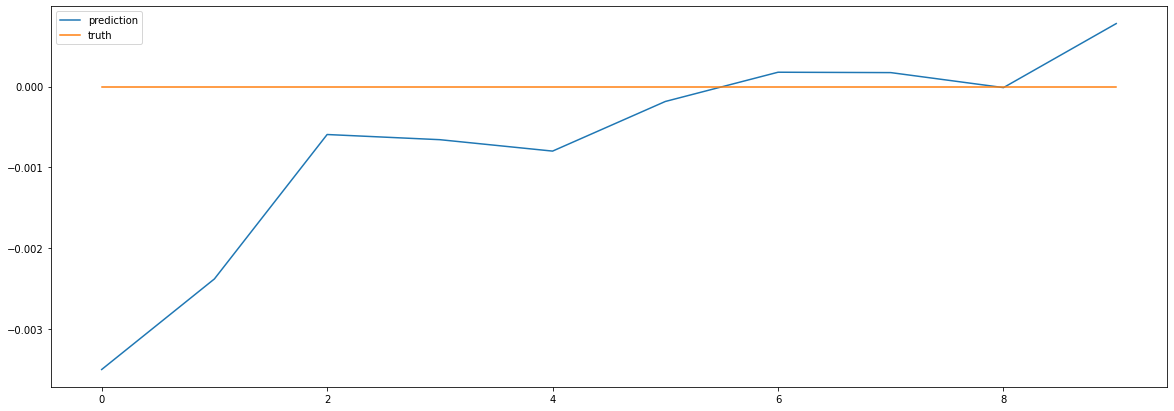

In [387]:
plt.figure(figsize = (20,7))
plt.plot(model.predict(np.array(X_test))[x], label= 'prediction')
plt.plot(y_test[x], label = 'truth')
plt.legend()

In [345]:
model.predict(np.array(X_test))[0]

array([0.1679672 , 0.17548251, 0.18243289, 0.17995653, 0.1814663 ,
       0.18294472, 0.18555197, 0.18465382, 0.17670569, 0.17938164],
      dtype=float32)

In [349]:
y_test.shape

(1050,)

In [16]:
df_transform[3000:3100]

array([0.09935976, 0.09935976, 0.09935976, 0.09935976, 0.09935976,
       0.09935976, 0.09935976, 0.09935976, 0.09026765, 0.09026765,
       0.09026765, 0.09026765, 0.09026765, 0.09026765, 0.09026765,
       0.09026765, 0.0936098 , 0.0936098 , 0.0936098 , 0.0936098 ,
       0.0936098 , 0.0936098 , 0.0936098 , 0.0936098 , 0.08868468,
       0.08868468, 0.08868468, 0.08868468, 0.08868468, 0.08868468,
       0.08868468, 0.08868468, 0.09096523, 0.09096523, 0.09096523,
       0.09096523, 0.09096523, 0.09096523, 0.09096523, 0.09096523,
       0.05490215, 0.05490215, 0.05490215, 0.05490215, 0.05490215,
       0.05490215, 0.05910011, 0.05070419, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     